In [1]:
# ridge svd?
#wanna go QR _or_ cholesky or what its called? check monday
#expand a bit to allow looping over noise weights?
#first mse r2 for low N?
#Most kFold versions look similar. introduce a "method" parameter and consolidate
#bias also increases with model complexity?

#validation set too?
#CENTER DATA?
#program likes cubic input, fix
# Ridge, 0 lambda best?
#VARIANCES SAME?!?!?!!?

#split in 3, train test to find poly degree, then use thiese betas with validation set to adjust hyperparameters?

In [2]:
#import packages
import numpy as np
import csv
from imageio import imread
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import scipy.linalg as scl
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso


# Function definitions

In [3]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [4]:
"""
This function creates the Model Matrix, usually dubbed X, for regression analysis.
It takes as input parameters a meshgrid of coordinates in the x and y direction, 
and the polynomial degree P that you wish to fit.

The order of columns is different from the one scikit learn creates, so take care to use the same model-creator when
comparing scikit and this code.

The ordering this function creates is: x^0y^0, x^1y^0, x^2y^0, x^0y^1, x^1y^1, x^0y^2 for a 2nd order polynomial.
"""
def Model(x,y,P): 
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [271]:
def ols_svd(X:np.ndarray, z:np.ndarray ,_lambda,method='ols')->np.ndarray:
    u, s, v = scl.svd(X)
    if method=='ols':
        return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z
    if method=='ridge':
        return (v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z)/(1+_lambda)

In [9]:
def VarOLS_betas(X, sigma):
    covar = np.linalg.inv(X.T.dot(X))
    vari = np.diagonal(covar)
    return vari*(sigma**2)

In [10]:
def VarRidge_betas(X,_lambda,sigma):
    XX = X.T@X
    invers = np.linalg.inv(XX+_lambda*np.eye(len(XX)))
    return np.diagonal(invers)*(sigma**2)

In [261]:
def NoResampling(X,z_n,_lambda,method='ols'):
    if method =='ols':
        beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
    elif method == 'svd':
        beta = np.ndarray(ols_svd(X,z_n))
    else:
        print("No method selected, defaulting to OLS")
        beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
    ztilde = X @ beta
    return MSE(z_n,ztilde), R2(z_n,ztilde), beta, VarOLS_betas(X,0.1)#,ztilde

In [12]:
def Bias(y_data, y_model):
    n = np.size(y_data)
    return np.sum((y_data-np.mean(y_model))**2)/n

In [462]:
def LatexPrinter(betas,variances):
    for i in range(len(betas)-1):#%.2f
        print("$\\beta_{{{}}}$ & {} & {} \\\ ".format(i,round(betas[i],7),round(variances[i],7)))
    print("$\\beta_{{{}}}$ & {} & {} \\\ \\hline".format(i+1,round(betas[i+1],7),round(variances[i+1],7)))

In [13]:
def Shuffler(X,z_n):
    np.random.seed(1234)
    n = len(X[0,:])
    combi = np.c_[X,z_n] #combine
    np.random.shuffle(combi) #shuffle
    X, z_n = combi[:,:n], combi[:,n] #split
    return X, z_n

In [14]:
def kSplitter(X,z,k):
    k = int(np.math.ceil((1./k)*len(X)))
    n,m = np.shape(X)
    ind = np.arange(0,n,k)
    for i in ind:
        X_test, z_test = X[i:(i+k),:],z[i:(i+k)]
        if i ==0:
            X_train,z_train = X[i+k:,:],z[i+k:]
        elif i ==(n-k):
            X_train,z_train = X[:i,:],z[:i]
        else:
            X_train = np.vstack([X[:i,:],X[i+k:,:]])
            z_train = np.hstack([z[:i],z[i+k:]])
        yield X_train, X_test, z_train, z_test

In [564]:
def kFolds(X,z_n,k,_lambda,method,sigma):
    #shuffle data before doing the kFold
    X_s,z_n_s = Shuffler(X,z_n)

    #initialize values
    err=[]
    bi =[]
    vari=[]
    test_size = int(len(z_n)*(1./k))
    train_size= len(z_n)-test_size

    z_test_pred=np.empty((test_size,k))
    z_train_pred=np.empty((train_size,k))

    c=0
    mse_test_eval = 0.
    mse_train_eval=0.
    
    r2_test_eval = 0.
    r2_train_eval=0.
    betas=[]
    beta_variances=[]
    for X_train_, X_test_, z_train_, z_test_ in kSplitter(X_s,z_n_s,k):
        #center data here
        X_train = X_train_ - np.mean(X_train_,axis=0)
        z_train = z_train_ - np.mean(z_train_)
        
        X_test  = X_test_  - np.mean(X_train_,axis=0)
        z_test  = z_test_  - np.mean(z_train_)
        
        X_train = np.delete(X_train,0,1)
        X_test = np.delete(X_test,0,1)
        
        # find parameters
        if method=='ols':
            beta = ols_svd(X_train,z_train,0.,'ols')
            beta_var = VarOLS_betas(X_train,sigma)
        if method=='ridge':
            beta = ols_svd(X_train,z_train,_lambda,'ridge')
            beta_var=VarRidge_betas(X_train,_lambda,sigma)
        if method =='LASSO':
            lassoing = Lasso(alpha=_lambda,fit_intercept=False, tol = 0.00000001, max_iter=1000000000)
            lassoing.fit(X_train,z_train)
            beta=lassoing.coef_
            beta_var=0.
        betas.append(beta)
        beta_variances.append(beta_var)
        
        # add centered stuff back
        z_test_pred[:,c] = X_test@beta+np.mean(z_train_)
        z_train_pred[:,c] = X_train@beta+np.mean(z_train_)

        mse_test_eval += np.mean((z_test_ - z_test_pred[:,c])**2,axis=0,keepdims=True)
        mse_train_eval += np.mean((z_train_ - z_train_pred[:,c])**2,axis=0,keepdims=True)
        
        r2_test_eval +=1-np.sum((z_test_-z_test_pred[:,c])**2,axis=0,keepdims=True)/np.sum((z_test_-np.mean(z_test_)**2),axis=0,keepdims=True)
        r2_train_eval +=1-np.sum((z_train_-z_train_pred[:,c])**2,axis=0,keepdims=True)/np.sum((z_train_-np.mean(z_train_)**2),axis=0,keepdims=True)
        c+=1
    return mse_test_eval/k, mse_train_eval/k,r2_test_eval/k, r2_train_eval/k,np.mean(betas,axis=0),np.mean(beta_variances,axis=0)

# plot over various noises

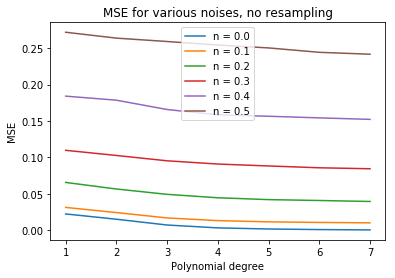

In [565]:
#Create random variables/predictors
N = 30 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

degrees=np.arange(1,20)
noises=np.linspace(0,0.5,6)
mse_ols_for_plot_out = []
MSE_RE = np.zeros((len(noises),len(degrees)))
for j,noi in enumerate(noises):
    Noise=noi*np.random.randn(N,N)
    z_noise = z+Noise
    z_n = np.matrix.flatten(z_noise)
    for i,deg in enumerate(degrees):
        X=Model(x,y,deg)
        mse_ols_no_re, r2_ols_no_re,beta_ols_no_re,beta_var_ols_no_re = NoResampling(X,z_n,0.,'ols')
        MSE_RE[j][i]=mse_ols_no_re
max_plot_degree=7
plt.figure()
for i in range(len(noises)):
    plt.plot(degrees[:max_plot_degree],MSE_RE[i,:max_plot_degree],label='n = {}'.format(round(noises[i],1)))
plt.xlabel('Polynomial degree')
plt.xticks(degrees[:max_plot_degree])
plt.ylabel('MSE')
plt.legend()
plt.title('MSE for various noises, no resampling')
plt.show()

# create plots of MSE/variance for all methods (one lambda for each regularization method)

In [566]:
#Create random variables/predictors
N = 30 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)

#number of folds for crossvalidation
k=5

#polydegrees to run
degrees=np.arange(1,20)

_lambda=0.1
_lambda_lasso=0.0001
#test vals
mse_ols_test =[]
mse_ridge_test=[]
mse_lasso_test=[]
r2_ols_test=[]
r2_ridge_test=[]
r2_lasso_test=[]

#train vals
mse_ols_train =[]
mse_ridge_train=[]
mse_lasso_train=[]
r2_ols_train=[]
r2_ridge_train=[]
r2_lasso_train=[]

#beta values
beta_ols=[]
beta_variance_ols=[]
beta_ridge=[]
beta_variance_ridge=[]
beta_LASSO = []
for deg in degrees:
    X = Model(x,y,deg)

    mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances = kFolds(X,z_n,k,_lambda,'ols',noise_weight)
    mse_ols_test.append(mse_te)
    mse_ols_train.append(mse_tr)
    r2_ols_test.append(r2_te)
    r2_ols_train.append(r2_tr)
    beta_ols.append(betas)
    beta_variance_ols.append(beta_variances)

    mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X,z_n,k,_lambda,'ridge',noise_weight)
    mse_ridge_test.append(mse_te)
    mse_ridge_train.append(mse_tr)
    r2_ridge_test.append(r2_te)
    r2_ridge_train.append(r2_tr)
    beta_ridge.append(betas)
    beta_variance_ridge.append(beta_variances)
    
    mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X,z_n,k,_lambda_lasso,'LASSO',noise_weight)
    mse_lasso_test.append(mse_te)
    mse_lasso_train.append(mse_tr)
    r2_lasso_test.append(r2_te)
    r2_lasso_train.append(r2_tr)
    beta_LASSO.append(betas)

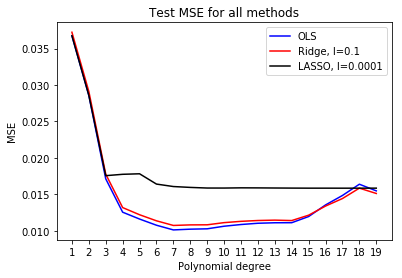

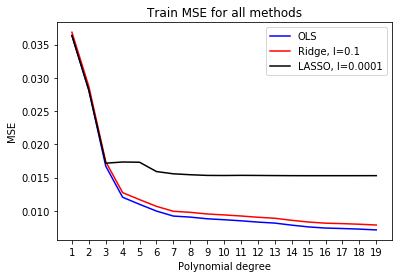

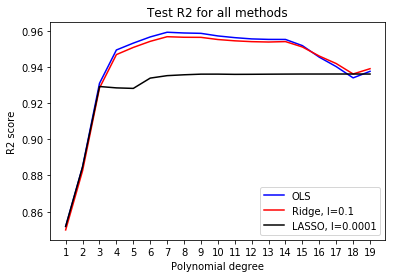

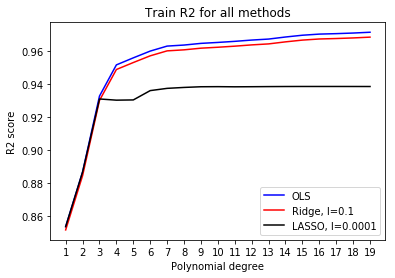

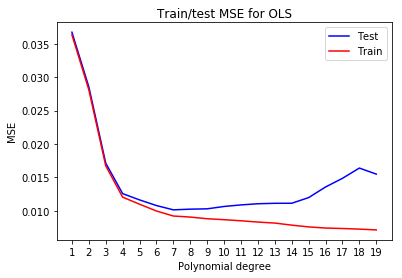

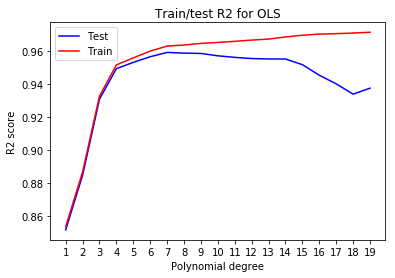

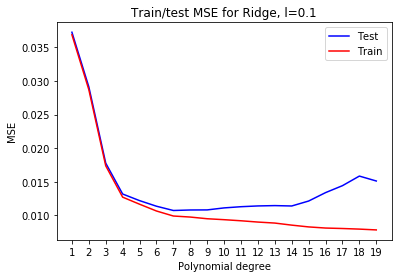

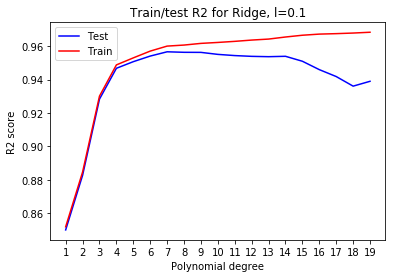

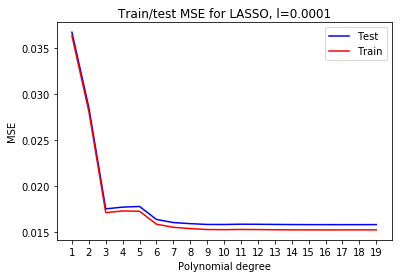

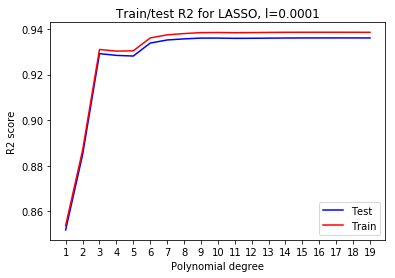

In [567]:
"""
Note that the reason for not automating the plotting for each fuction/scoring 
is that we might want to personalize each plot.
"""
plt.figure()
plt.plot(degrees,mse_ols_test,'b',label='OLS')
plt.plot(degrees,mse_ridge_test,'r',label='Ridge, l={}'.format(_lambda))
plt.plot(degrees,mse_lasso_test,'k',label='LASSO, l={}'.format(_lambda_lasso))
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('MSE')
plt.title('Test MSE for all methods')
plt.show()

plt.figure()
plt.plot(degrees,mse_ols_train,'b',label='OLS')
plt.plot(degrees,mse_ridge_train,'r',label='Ridge, l={}'.format(_lambda))
plt.plot(degrees,mse_lasso_train,'k',label='LASSO, l={}'.format(_lambda_lasso))
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('MSE')
plt.title('Train MSE for all methods')
plt.show()

plt.figure()
plt.plot(degrees,r2_ols_test,'b',label='OLS')
plt.plot(degrees,r2_ridge_test,'r',label='Ridge, l={}'.format(_lambda))
plt.plot(degrees,r2_lasso_test,'k',label='LASSO, l={}'.format(_lambda_lasso))
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('R2 score')
plt.title('Test R2 for all methods')
plt.show()

plt.figure()
plt.plot(degrees,r2_ols_train,'b',label='OLS')
plt.plot(degrees,r2_ridge_train,'r',label='Ridge, l={}'.format(_lambda))
plt.plot(degrees,r2_lasso_train,'k',label='LASSO, l={}'.format(_lambda_lasso))
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('R2 score')
plt.title('Train R2 for all methods')
plt.show()

################################################################
plt.figure()
plt.plot(degrees,mse_ols_test,'b',label='Test')
plt.plot(degrees,mse_ols_train,'r',label='Train')
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('MSE')
plt.title('Train/test MSE for OLS')
plt.show()

plt.figure()
plt.plot(degrees,r2_ols_test,'b',label='Test')
plt.plot(degrees,r2_ols_train,'r',label='Train')
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('R2 score')
plt.title('Train/test R2 for OLS')
plt.show()
##################################################################
plt.figure()
plt.plot(degrees,mse_ridge_test,'b',label='Test')
plt.plot(degrees,mse_ridge_train,'r',label='Train')
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('MSE')
plt.title('Train/test MSE for Ridge, l={}'.format(_lambda))
plt.show()

plt.figure()
plt.plot(degrees,r2_ridge_test,'b',label='Test')
plt.plot(degrees,r2_ridge_train,'r',label='Train')
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('R2 score')
plt.title('Train/test R2 for Ridge, l={}'.format(_lambda))
plt.show()
#####################################################################
plt.figure()
plt.plot(degrees,mse_lasso_test,'b',label='Test')
plt.plot(degrees,mse_lasso_train,'r',label='Train')
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('MSE')
plt.title('Train/test MSE for LASSO, l={}'.format(_lambda_lasso))
plt.show()

plt.figure()
plt.plot(degrees,r2_lasso_test,'b',label='Test')
plt.plot(degrees,r2_lasso_train,'r',label='Train')
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('R2 score')
plt.title('Train/test R2 for LASSO, l={}'.format(_lambda_lasso))
plt.show()

# create confidence interval for resampling, ols

In [479]:
poly_degrees=np.arange(0,6)

print("With k-fold resampling")
for i in poly_degrees:
    print("---------------")
    print("\\begin{table}[]")
    print("\\centering")
    print("\\caption{{OLS method, polynomial degree {}}}".format(i))
    print("\\begin{tabular}{|c|cc|l|}")
    print("\\hline")
    print("\\multicolumn{1}{|l|}{\\multirow{2}{*}{Coefficient}} & \\multicolumn{2}{l|}{Confidence interval = $\\beta_{mean}$ $\\pm$ 2*$\\sigma_{mean}$} \\\\")
    print("\\multicolumn{1}{|l|}{}  & $\\beta_{mean}$                        & $\\sigma_{mean}$                       &                                     \\\\ \hline")   
    Betas_OLS = beta_ols[i]
    Beta_Variances_OLS = beta_variance_ols[i]
    LatexPrinter(Betas_OLS,Beta_Variances_OLS)
    print("\\end{tabular}")
    print("\\label{{tab:ols_no.{}}}".format(i))
    print("\\end{table}")

With k-fold resampling
---------------
\begin{table}[]
\centering
\caption{OLS method, polynomial degree 0}
\begin{tabular}{|c|cc|l|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                       &                                     \\ \hline
$\beta_{0}$ & 0.851021 & 0.0001155 \\ 
$\beta_{1}$ & -0.3738545 & 0.0001531 \\ 
$\beta_{2}$ & -0.5753418 & 0.0001805 \\ \hline
\end{tabular}
\label{tab:ols_no.0}
\end{table}
---------------
\begin{table}[]
\centering
\caption{OLS method, polynomial degree 1}
\begin{tabular}{|c|cc|l|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                       &                                  

# create confidence interval for resampling, Ridge

In [480]:
poly_degrees=np.arange(0,6)

print("For k-fold resapmling")
for i in poly_degrees:
    print("---------------")
    print("\\begin{table}[]")
    print("\\centering")
    print("\\caption{{Ridge method, polynomial degree {}}}".format(i))
    print("\\begin{tabular}{|c|cc|l|}")
    print("\\hline")
    print("\\multicolumn{1}{|l|}{\\multirow{2}{*}{Coefficient}} & \\multicolumn{2}{l|}{Confidence interval = $\\beta_{mean}$ $\\pm$ 2*$\\sigma_{mean}$} \\\\")
    print("\\multicolumn{1}{|l|}{}  & $\\beta_{mean}$                        & $\\sigma_{mean}$                       &                                     \\\\ \hline")   
    Betas_Ridge = beta_ridge[i]
    Beta_Variances_Ridge = beta_variance_ridge[i]
    LatexPrinter(Betas_Ridge,Beta_Variances_Ridge)
    print("\\end{tabular}")
    print("\\label{{tab:ridge_no.{}}}".format(i))
    print("\\end{table}")

For k-fold resapmling
---------------
\begin{table}[]
\centering
\caption{Ridge method, polynomial degree 0}
\begin{tabular}{|c|cc|l|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                       &                                     \\ \hline
$\beta_{0}$ & 0.7736554 & 0.0001152 \\ 
$\beta_{1}$ & -0.3398677 & 0.0001528 \\ 
$\beta_{2}$ & -0.523038 & 0.0001801 \\ \hline
\end{tabular}
\label{tab:ridge_no.0}
\end{table}
---------------
\begin{table}[]
\centering
\caption{Ridge method, polynomial degree 1}
\begin{tabular}{|c|cc|l|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                       &                             

# create confidence interval for resampling, LASSO

In [ ]:

_lambda=0.1
_lambda_lasso=0.0001
#test vals
mse_ols_test =[]
mse_ridge_test=[]
mse_lasso_test=[]
r2_ols_test=[]
r2_ridge_test=[]
r2_lasso_test=[]

#train vals
mse_ols_train =[]
mse_ridge_train=[]
mse_lasso_train=[]
r2_ols_train=[]
r2_ridge_train=[]
r2_lasso_train=[]

#beta values
beta_ols=[]
beta_variance_ols=[]
beta_ridge=[]
beta_variance_ridge=[]
beta_LASSO = []
for deg in degrees:
    X = Model(x,y,deg)

    mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances = kFolds(X,z_n,k,_lambda,'ols',noise_weight)
    mse_ols_test.append(mse_te)
    mse_ols_train.append(mse_tr)
    r2_ols_test.append(r2_te)
    r2_ols_train.append(r2_tr)
    beta_ols.append(betas)
    beta_variance_ols.append(beta_variances)

    mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X,z_n,k,_lambda,'ridge',noise_weight)
    mse_ridge_test.append(mse_te)
    mse_ridge_train.append(mse_tr)
    r2_ridge_test.append(r2_te)
    r2_ridge_train.append(r2_tr)
    beta_ridge.append(betas)
    beta_variance_ridge.append(beta_variances)
    
    mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X,z_n,k,_lambda_lasso,'LASSO',noise_weight)
    mse_lasso_test.append(mse_te)
    mse_lasso_train.append(mse_tr)
    r2_lasso_test.append(r2_te)
    r2_lasso_train.append(r2_tr)
    beta_LASSO.append(betas)

# Ridge plotting for various lambda and polynomial degrees

In [571]:
#Create random variables/predictors
N = 30 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)

#number of folds for crossvalidation
k=5

#polydegrees to run
degrees=np.arange(1,10)

# nlambdas = 100
# _lambdas = np.logspace(-5, 0, nlambdas)

nlambdas = 100
lambdas = np.logspace(-3, 5, nlambdas)
#test vals
mse_ridge_test=[]
r2_ridge_test=[]

#train vals
mse_ridge_train=[]
r2_ridge_train=[]

mse_min = 10000  #huge value at start
MSE_RIDGE = np.zeros((len(_lambdas),len(degrees)))
for i,_lambda in enumerate(_lambdas): 
    for j,deg in enumerate(degrees):
        X = Model(x,y,deg)
        X_s = X
        z_n_s = z_n


        mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X_s,z_n_s,k,_lambda,'ridge',noise_weight)
        MSE_RIDGE[i][j] = mse_te
        if mse_te < mse_min:
            mse_min=mse_te
            _lambda_best = i
            _degree_best = j
print(mse_min,_lambdas[i],degrees[j])

[0.01138488] 1.0 19


In [ ]:
max_plot_degree=100
plt.figure()
for i in range(90,len(_lambdas)):
    plt.plot(degrees[:max_plot_degree],MSE_RIDGE[i][:max_plot_degree],label='l = {}'.format(_lambdas[i]))
plt.legend()
plt.show()

# lambdas for lasso

In [ ]:
#Create random variables/predictors
N = 30 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)

#number of folds for crossvalidation
k=5

#polydegrees to run
degrees=np.arange(1,10)

nlambdas = 100
lambdas = np.logspace(-3, 5, nlambdas)
#test vals
mse_ridge_test=[]
r2_ridge_test=[]

#train vals
mse_ridge_train=[]
r2_ridge_train=[]
mse_min=100000.
MSE_LASSO = np.zeros((len(_lambdas),len(degrees)))
for i,_lambda in enumerate(_lambdas): 
    for j,deg in enumerate(degrees):
        X = Model(x,y,deg)
        X_s = X
        z_n_s = z_n


        mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X_s,z_n_s,k,_lambda,'LASSO',noise_weight)
        MSE_LASSO[i][j] = mse_te
        if mse_te < mse_min:
            mse_min=mse_te
            _lambda_best = i
            _degree_best = j
print(mse_min,i,j)

In [ ]:
max_plot_degree=10
plt.figure()
for i in range(len(_lambdas)-1):
    plt.plot(degrees[:max_plot_degree],MSE_LASSO[i][:max_plot_degree],label='l = {}'.format(_lambdas[i]))
plt.legend()
plt.show()

# Do stuff with the code!

In [ ]:
terrain = imread('SRTM_data_Norway_1.tif')
terr_square = terrain[0:100,0:100]
print(np.shape(terr_square))

In [ ]:
terra = np.matrix.flatten(terr_square)
print(np.shape(terra))
# x = np.linspace(0,len(terr_square[0]),100)
# y = np.linspace(0,len(terr_square[1]),100)
x = np.linspace(0,1,np.sqrt(len(terra)))
y=np.linspace(0,1,np.sqrt(len(terra)))
x, y = np.meshgrid(x,y,sparse=False)


In [ ]:
X = Model(x,y,5)


X_c = X-np.mean(X,axis=0)
X_c[:,0]=1.
terra_c = terra -np.mean(terra)

In [ ]:
NoResampling(X,terra,0.)

In [ ]:
betas=[]
mpd = 6
for i in range(mpd):
        X = Model(xp,yp,i+1)
        print(np.shape(X))
#         model_values[l,i] = kFoldskl(k,X,z_n)[0]
#         model_values[l,i] = kFold(k,X,z_n)[0]
#         NMSE_k[l,i] = MSE(model_values[l,i],z_n_sorted)
#         if l == 0:
        betas.append(kFold(k,X,terra)[1])

In [ ]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
# xp = np.arange(0,1,0.05)
# yp = np.arange(0,1,0.05)


xp = np.linspace(0,1,len(terr_square[0]))
yp=np.linspace(0,1,len(terr_square[1]))

xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
# fz = FrankeFunction(xp,yp)


betas=[]
for i in range(pd):
        X = Model(xp,yp,i+1)
        betas.append(kFold(k,X,terra)[1])

for i in range(pd):
    axs = fig.add_subplot(3,3,i+1,projection='3d')
    Xp = Model(xp,yp,i+1)
    zp = Xp@betas[i]
    zp.shape=(len(xp),len(yp))
    axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
#     axs.plot_surface(xp,yp,terr_square,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_zlabel('z')
    axs.set_title('Polynomial degree = {}'.format(i+1))
#     axs.set_zlim(-0.10,1.40)
    axs.zaxis.set_major_locator(LinearLocator(10))
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [ ]:
fig2 = plt.figure()
axers = fig2.gca(projection='3d')

for i in range(pd):
    surf = axers.plot_surface(xp,yp,terr_square,cmap=cm.coolwarm,linewidth=0,antialiased=False)
plt.show()

In [ ]:
pd = 5
_lams = np.linspace(0.0,1.,10)
X = Model(x,y,pd)
fish=[]
for i in range(len(_lams)):
    fish.append(kFoldRidge(k,X,z_n,i))

In [394]:
a=[1,2,3]
print(np.shape(a))
b=a[:,np.newaxis]
print(np.shape(b))

(3,)


TypeError: list indices must be integers or slices, not tuple

In [ ]:
import pandas as pd

data = pd.read_csv("Oppgave_a.csv")
# row2 = data.iloc[3]
# print(row2)

In [440]:
def LatexPrinter(betas,variances):
    for i in range(len(betas)-1):#%.2f
        print("$\\beta_{{{}}}$ & {} & {} \\\ ".format(i,round(betas[i],7),round(variances[i],7)))
    print("$\\beta_{{{}}}$ & {} & {} \\\ \\hline".format(i,round(betas[i],7),round(variances[i],7)))

In [ ]:















terrain = imread('SRTM_data_Norway_1.tif')
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.xlabel('Y')
plt.show()

In [ ]:
terrain = imread('SRTM_data_Norway_1.tif')
terr_square = terrain[0:10,0:10]
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terr_square, cmap='gray')
plt.xlabel('X')
plt.xlabel('Y')
plt.show()
terr_flat = np.matrix.flatten(terr_square)

In [ ]:
x = np.linspace(0,1,10)
y = np.linspace(0,1,10)
x,y = np.meshgrid(x,y)

In [ ]:
ols_svds = []

poly_degrees = np.arange(1,6)
for i in poly_degrees:
    X = Model(x,y,i)
# #     ols_mse.append(NoResampling(X,z_n,0.,'ols')[0])
    ols_svds.append(NoResampling(X,terr_flat,0.,'svd')[0])
plt.figure()
# # plt.plot(poly_degrees,ols_mse,'r',label='OLS')
plt.plot(poly_degrees,ols_svds,'b',label='SVD')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, no resampling")
plt.show()

In [ ]:
ols_k_mse = []
ols_k_bias = []
ols_k_var = []
ols_k_r2 = []
ols_k_r2_tr = []
ols_k_mse_tr = []
_lambda = 0.
poly_degrees = np.arange(1,8)
for i in poly_degrees:
    X = Model(x,y,i)
    X_s = X
    z_n_s = terr_flat
    X_s,z_n_s = Shuffler(X_s,z_n_s)
    
    mii,bii,vii,til,tes,bet,rr2,msetr, r2tr = kFolds(X_s,z_n_s,10)
#     ols_k_mse.append(MSE(til,tes))
    ols_k_mse.append(mii)
    ols_k_mse_tr.append(msetr)
#     ols_k_r2_tr.append(r2tr)
#     ols_k_var.append(np.var(til))
#     ols_k_bias.append(Bias(tes,til))
#     ols_k_r2.append(R2(tes,til))
# print(ols_k_mse[4])
# print(ols_k_r2[4])
# print(ols_k_mse_tr[4])
# print(ols_k_r2_tr[4])

plt.figure()
plt.plot(poly_degrees,ols_k_mse,'r',label='MSE')
# plt.plot(poly_degrees,ols_k_bias,'b',label='Bias^2')
# plt.plot(poly_degrees,ols_k_var,'y',label='Var')
plt.xlabel("Polynomial degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MSE for OLS, kFold resampling. Method 1")
plt.show()


# jols_k_mse = []
# jols_k_bias = []
# jols_k_var = []
# for i in poly_degrees:
#     X = Model(x,y,i)
#     X_s = X
#     z_n_s = z_n
#     X_s,z_n_s = Shuffler(X_s,z_n_s)

#     mii,bii,vii,til,tes,bet = kFold(X_s,z_n_s,10,0.)
#     jols_k_mse.append(np.mean(mii))
#     jols_k_var.append(np.mean(vii))
#     jols_k_bias.append(np.mean(bii))
    
# plt.figure()
# plt.plot(poly_degrees,jols_k_mse,'r',label='MSE')
# # plt.plot(poly_degrees,jols_k_bias,'b',label='Bias^2')
# # plt.plot(poly_degrees,jols_k_var,'y',label='Var')
# plt.xlabel("Polynomial degree")
# plt.ylabel("Mean Squared Error")
# plt.legend()
# plt.title("MSE for OLS, kFold resampling. Method 2")
# plt.show()
